# MODEL

In [5]:
import numpy as np
import torch 
import matplotlib.pyplot as plt
import enum

import os
from PIL import Image
import cv2 #pip install opencv-python
import torchvision.transforms as transforms
import matplotlib.image as mpimg
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50
from torchvision import datasets, models, transforms
import torchvision
import copy
import sklearn.metrics
import time
import torch.utils
import torch.utils.data
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

Reeee

In [6]:
# import import_ipynb
# import proeprocess
%run preprocess.ipynb
%run stinna.ipynb
%run extraFunctions.ipynb

# from stinna import plot_confusion_matrix, plot_accuracies
# # from extraFunctions import makeAll, visualize_model, imshow
# from preprocess import *

ResNet accepts input images of shape `(3 x 224 x 224)` and they must be loaded in to a range of `[0,1]` and normalised using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]` (https://pytorch.org/hub/pytorch_vision_resnet/). Our data already has the correct size, so here, we simply add `ToTensor()`, which converts the images from `(H x W x C)` in range `[0,255]` to `(C x H x W)` in range `[0.0,1.0]`, and the normalisation. 

In [14]:
simple_transformer = transforms.Compose([
        transforms.ToTensor()])

In [7]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [16]:
# same as a above (which is the plain preprocessing), but with augmentations added
preprocess_with_augmentation1 = transforms.Compose([
    transforms.ColorJitter(brightness=0.1),
    transforms.GaussianBlur(kernel_size=(5,5), sigma=(7, 9)),
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Split data into train set, validation set and test set with ratio 80/10/10

In [22]:
# import splitfolders
# splitfolders.ratio(PATHbirdsWithBackground, output="output",seed=42, ratio=(0.8,0.1,0.1) )

Set up paths to data and dataloaders for traning set and validation set

In [17]:
PATH_TEST = "split_withbackground/test"
test_set = datasets.ImageFolder(PATH_TEST, simple_transformer)
dataset_test = datasets.ImageFolder(PATH_TEST, preprocess)

PATH_TRAIN = "split_withbackground/train"
train_set = datasets.ImageFolder(PATH_TRAIN, simple_transformer)
train_aug = datasets.ImageFolder(PATH_TRAIN, preprocess)
dataset_train = datasets.ImageFolder(PATH_TRAIN, preprocess)
dataset_train_aug1 = datasets.ImageFolder(PATH_TRAIN, preprocess_with_augmentation1)

PATH_VAL = "split_withbackground/val"
val_set = datasets.ImageFolder(PATH_VAL, simple_transformer)
val_aug = datasets.ImageFolder(PATH_VAL, preprocess)
dataset_val = datasets.ImageFolder(PATH_VAL, preprocess)
dataset_val_aug1 = datasets.ImageFolder(PATH_VAL, preprocess_with_augmentation1)

class_labels = val_set.classes
print('Labels: {}'.format(class_labels))

PATH_FEEDER = "feeder-data"
feeder_set = datasets.ImageFolder(PATH_FEEDER, simple_transformer) # FIXME hvorfor simple_transformer (som ikke har normaliseringen) og ikke preprocess?
feeder_size = len(feeder_set)
print('Labels: {}'.format(feeder_set.classes))

dataset_size_train = len(train_set)
dataset_size_val = len(val_set)
print('No of images in training set: {}'.format(dataset_size_train))
print('No of images in validation set: {}'.format(dataset_size_val))
print('No of images in test set: {}'.format(len(test_set)))
print('No of images in feeder set: {}'.format(feeder_size))

Labels: ['blueTit', 'chaffinch', 'coalTit', 'goldfinch', 'greatTit', 'robin', 'starling']
Labels: ['blueTit', 'chaffinchF', 'chaffinchM', 'coalTit', 'goldfinch', 'greatTit', 'robin', 'starling']
No of images in training set: 835
No of images in validation set: 104
No of images in test set: 105
No of images in feeder set: 15079


In [21]:
# Base versions
dataloader_train = torch.utils.data.DataLoader(train_aug, batch_size=4, shuffle=True, num_workers=4)
dataloader_validation = torch.utils.data.DataLoader(val_aug, batch_size=4, shuffle=True, num_workers=4)
dataloader_test = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=False, num_workers=4)
dataloader_feeder = torch.utils.data.DataLoader(feeder_set, batch_size=4, shuffle=False, num_workers=4)

# Augmentation round 1
dataloader_train_aug1 = torch.utils.data.DataLoader(dataset_train_aug1, batch_size=4, shuffle=True, num_workers=4)
dataloader_val_aug1 = torch.utils.data.DataLoader(dataset_val_aug1, batch_size=4, shuffle=True, num_workers=4)

# Extracting a subset to be able to test our code before doing big boi training
subset1 = torch.utils.data.Subset(train_aug, np.random.choice(len(train_aug), 16, replace=False))
subset2 = torch.utils.data.Subset(val_aug, [1,8,9,16, 60, 80, 98, 100, 103, 20,31, 40,50,70,90,88])
print(subset1.dataset)
print(subset1.indices)
print(subset2.dataset)
print(subset2.indices)
dataloader_tiny = DataLoader(subset1, batch_size=4, shuffle=True, num_workers=0)
dataloader_tiny_val = DataLoader(subset2, batch_size=4, shuffle=True, num_workers=0)
# dataloader_aug = torch.utils.data.DataLoader(train_aug, batch_size=4, shuffle=True, num_workers=4)

Dataset ImageFolder
    Number of datapoints: 835
    Root location: split_withbackground/train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
[122 117 610 589 613 825 144 214 315 711 806 616 121 714 179 455]
Dataset ImageFolder
    Number of datapoints: 104
    Root location: split_withbackground/val
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
[1, 8, 9, 16, 60, 80, 98, 100, 103, 20, 31, 40, 50, 70, 90, 88]


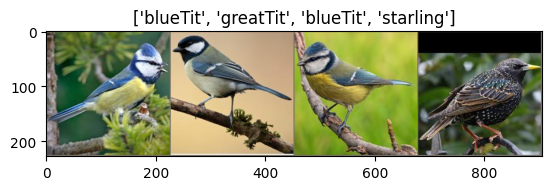

In [ ]:
# # Same as above, expect that we are using augmentation_transformer
inputs, classes = next(iter(dataloader_tiny_val))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[train_set.classes[x] for x in classes])


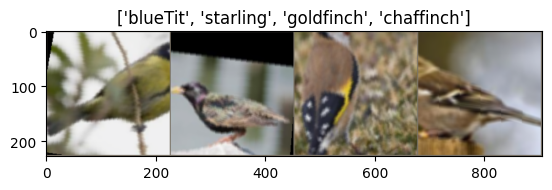

In [22]:
# looking at the augmentations..
inputs, classes = next(iter(dataloader_train_aug1))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[train_set.classes[x] for x in classes])

Import ResNet50 model with the pretrained weights  
https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet50.html#torchvision.models.resnet50

In [23]:
pretrained_weigths = models.ResNet50_Weights.DEFAULT
def load_model(weigths = pretrained_weigths):
    model = resnet50(weights=weigths)
    print(model)
    #Replace last layer to match 7 classes
    model.fc = torch.nn.Linear(model.fc.in_features, 7)
    print(model.fc)
    return model
model = load_model()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\stinn/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 50.9MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Inference transforms perform the following preprocessing operations:  
- Accepts PIL.Image, batched (B, C, H, W) and single (C, H, W) image torch.Tensor objects.  
- The images are resized to resize_size=[232] using interpolation=InterpolationMode.BILINEAR, followed by a central crop of crop_size=[224].  
- Finally the values are first rescaled to [0.0, 1.0] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].

Put the pedal to the medal and use GPU

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [25]:
def train_model(model, optimizer, num_epoch=5, train = dataloader_train, validation= dataloader_validation):
    acc_train = []
    loss_train = []
    acc_validation = []
    loss_validation = []
    best_acc = 0.0
    best_model_weight = copy.deepcopy(model.state_dict())

    since = time.time()
    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch+1, num_epoch))
        print("-"*10)
        #training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in train:
            inputs = inputs.to(device)
            labels = labels.to(device)

            #zero the parameter gradients 
            optimizer.zero_grad()

            #forward
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                criterion = torch.nn.CrossEntropyLoss()
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss_train = running_loss / dataset_size_train
        epoch_acc_train = running_corrects.double() / dataset_size_train
        acc_train.append(epoch_acc_train.item())
        loss_train.append(epoch_loss_train)
        print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_train, epoch_acc_train))

        #validation phase
        model.eval()
        running_loss_val = 0.0
        running_corrects_val = 0
        for inputs, labels in validation:
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                criterion = torch.nn.CrossEntropyLoss()
                loss = criterion(outputs, labels)
            running_loss_val += loss.item() * inputs.size(0)
            running_corrects_val += torch.sum(preds == labels.data)
        epoch_loss_val = running_loss_val / dataset_size_val
        epoch_acc_val = running_corrects_val.double() / dataset_size_val
        acc_validation.append(epoch_acc_val.item())
        loss_validation.append(epoch_loss_val)
        print('Val Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_val, epoch_acc_val))
        
        if(epoch_acc_val > best_acc):
            best_acc = epoch_acc_val
            best_model_weight = copy.deepcopy(model.state_dict())
        
        time_epoch_val = time.time() - since           
        print('Epoch time {:.0f}m {:.0f}s'.format(time_epoch_val // 60, time_epoch_val % 60))
        print("-"*10)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Validation accuracies:")
    print(acc_validation)
    data = {"train_loss": loss_train, "val_loss": loss_validation, "train_acc": acc_train, "val_acc": acc_validation}
    model.load_state_dict(best_model_weight)
    return model, data


In [26]:
# Freeze all layers (i.e., disable training so we dont start from scratch)
for param in model.parameters():
    param.requires_grad = False

# Unfreeze final layer (named fc) s.t. we only train that to get a better starting point for fine tuning
for param in model.fc.parameters():
    param.requires_grad = True

# Put the model on the GPU
model = model.to(device)

#Use stochastic gradient descent and optimize parameters
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


## Training from 7/11

In [13]:
trained, data = train_model(model=model,optimizer=optimizer, num_epoch=10, train=dataloader_train, validation=dataloader_validation) #took like 4 minutes on device
print(data)

Epoch 1/10
----------
Train Loss: 1.6768 Acc: 0.5473
Val Loss: 1.2883 Acc: 0.8077
Epoch time 1m 47s
----------

Epoch 2/10
----------
Train Loss: 1.2158 Acc: 0.8407
Val Loss: 0.9681 Acc: 0.8558
Epoch time 3m 26s
----------

Epoch 3/10
----------
Train Loss: 0.9520 Acc: 0.8862
Val Loss: 0.7650 Acc: 0.9615
Epoch time 5m 33s
----------

Epoch 4/10
----------
Train Loss: 0.8127 Acc: 0.8958
Val Loss: 0.6107 Acc: 0.9231
Epoch time 7m 30s
----------

Epoch 5/10
----------
Train Loss: 0.7028 Acc: 0.9126
Val Loss: 0.4954 Acc: 0.9519
Epoch time 9m 28s
----------

Epoch 6/10
----------
Train Loss: 0.6361 Acc: 0.9150
Val Loss: 0.4703 Acc: 0.9519
Epoch time 11m 11s
----------

Epoch 7/10
----------
Train Loss: 0.5800 Acc: 0.9234
Val Loss: 0.3887 Acc: 0.9808
Epoch time 12m 57s
----------

Epoch 8/10
----------
Train Loss: 0.5333 Acc: 0.9317
Val Loss: 0.3786 Acc: 0.9904
Epoch time 14m 52s
----------

Epoch 9/10
----------
Train Loss: 0.4972 Acc: 0.9329
Val Loss: 0.4069 Acc: 0.9712
Epoch time 16m 36s


In [14]:
model = trained
# Unfreeze all layers such that we can fine-tune the model
for param in model.parameters():
    param.requires_grad = True

model, data = train_model(model, optimizer, num_epoch=6, train=dataloader_train, validation=dataloader_validation) #took like 24 min

Epoch 1/6
----------
Train Loss: 0.2568 Acc: 0.9281
Val Loss: 0.1000 Acc: 0.9904
Epoch time 4m 54s
----------

Epoch 2/6
----------
Train Loss: 0.0926 Acc: 0.9796
Val Loss: 0.0915 Acc: 0.9712
Epoch time 9m 56s
----------

Epoch 3/6
----------
Train Loss: 0.0462 Acc: 0.9868
Val Loss: 0.0584 Acc: 0.9808
Epoch time 14m 47s
----------

Epoch 4/6
----------
Train Loss: 0.0392 Acc: 0.9928
Val Loss: 0.0612 Acc: 0.9808
Epoch time 20m 0s
----------

Epoch 5/6
----------
Train Loss: 0.0287 Acc: 0.9976
Val Loss: 0.0493 Acc: 0.9904
Epoch time 25m 11s
----------

Epoch 6/6
----------
Train Loss: 0.0237 Acc: 0.9964
Val Loss: 0.0522 Acc: 0.9808
Epoch time 30m 19s
----------

Training complete in 30m 19s
Validation accuracies:
[0.9903846153846154, 0.9711538461538461, 0.9807692307692307, 0.9807692307692307, 0.9903846153846154, 0.9807692307692307]


In [ ]:
# visualize_model(model)

# # plt.ioff()
# # plt.ion()
# plt.show()

In [11]:
%run stinna.ipynb

truel, predl = makeAll(dataloader_validation, model, device)

plot_confusion_matrix(truel, predl, class_labels)

NameError: name 'dataloader_validation' is not defined

In [ ]:
plot_confusion_matrix(truel, predl, class_labels)

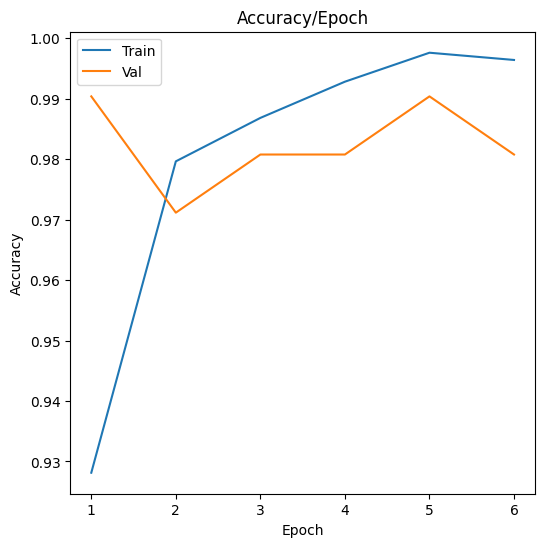

In [34]:
plot_accuracies(data["train_acc"], data["val_acc"], ["Train", "Val"])

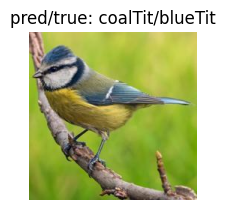

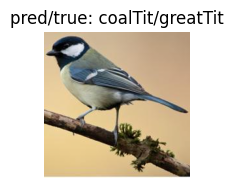

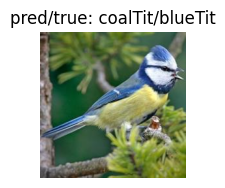

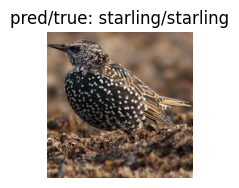

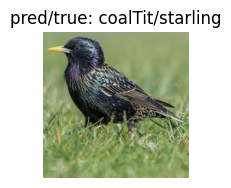

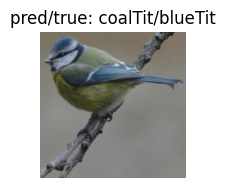

In [71]:
visualize_model(model, dataloader_tiny_val, train_set.classes, device)

In [ ]:
truel, predl = makeAll(dataloader_validation, model, device)

plot_confusion_matrix(truel, predl, class_labels)

Accuracy 94.28571428571428
[[15  0  0  0  0  0  0]
 [ 0 15  0  0  0  0  0]
 [ 0  0 14  0  0  0  1]
 [ 0  0  0 15  0  0  0]
 [ 1  0  4  0 10  0  0]
 [ 0  0  0  0  0 15  0]
 [ 0  0  0  0  0  0 15]]


<AxesSubplot: title={'center': 'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

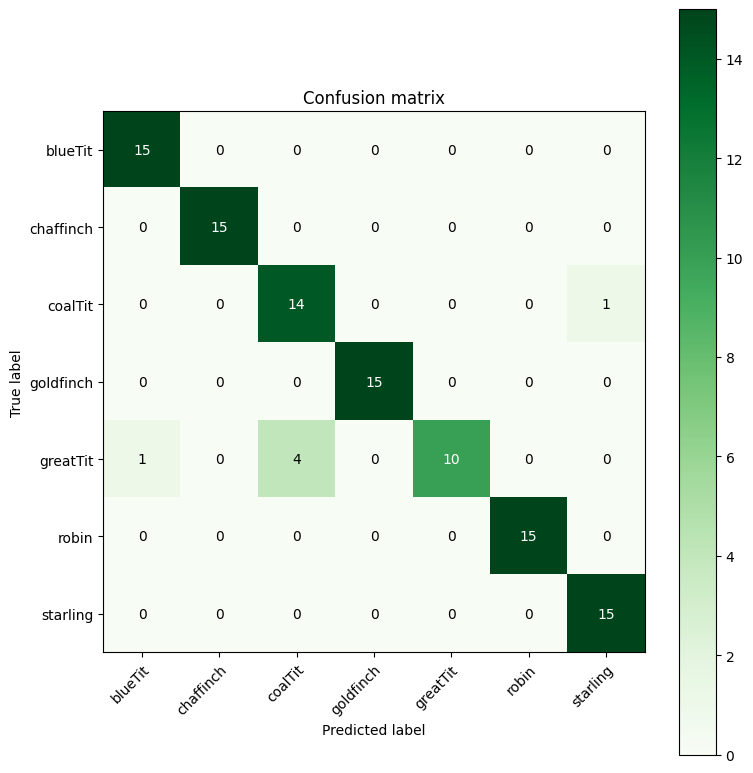

In [ ]:
truel, predl = makeAll(dataloader_test, model, device)

print("Accuracy", (np.sum(predl==truel)/predl.size * 100))
plot_confusion_matrix(truel, predl, class_labels)

Accuracy 46.87313482326414
[[ 560   26  358  102  409  267  356]
 [ 300  835  580  708  152  578  399]
 [ 126   40 1134  101  126   16  303]
 [   7    5  263 1622   35   46   22]
 [ 260   17  464  116  505  175  496]
 [ 172  100   18   70    0  849  219]
 [  20    9  333   60   38  119 1563]]


<AxesSubplot: title={'center': 'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

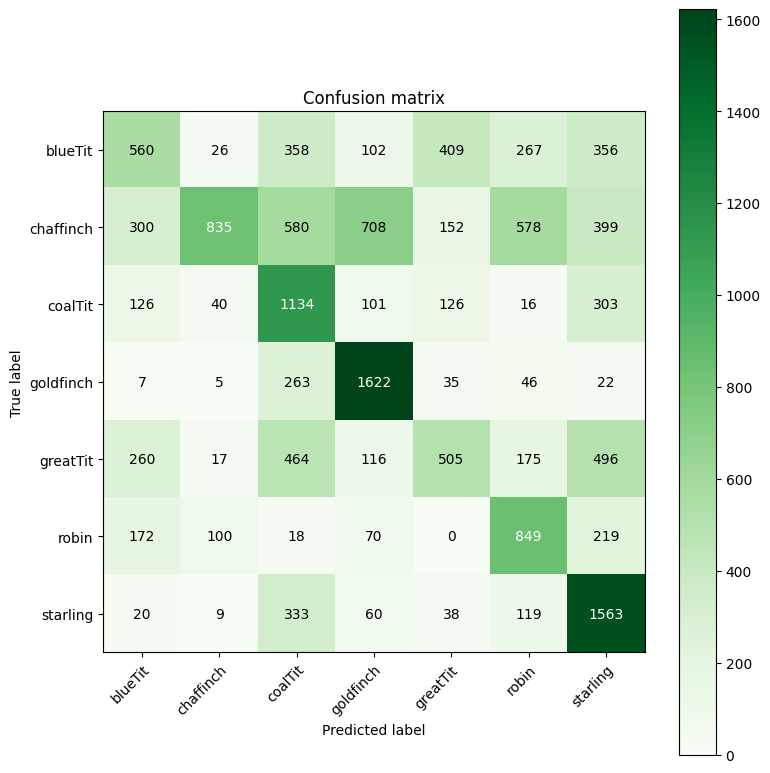

In [26]:
truel, predl = makeAll(dataloader_feeder, model, device)

print("Accuracy", (np.sum(predl==truel)/predl.size * 100))
plot_confusion_matrix(truel, predl, class_labels)

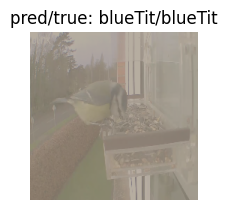

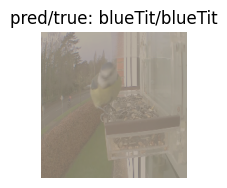

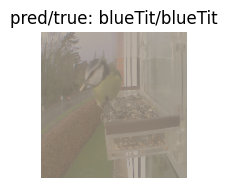

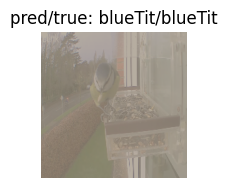

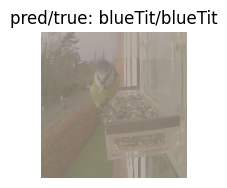

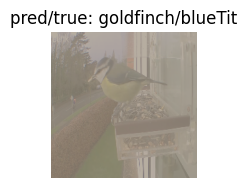

In [25]:
visualize_model(model, dataloader_feeder, train_set.classes, device)

## Training with augmentation

Now we've trained our model and assessed its performance on the feeder data... it's not the worst, but let's see if we can't make it a bit stronger by adding augmentations.